## Variational Autoencoder (VAE) on MNIST (PyTorch)

Train a simple VAE to reconstruct and sample MNIST digits. Configure hyperparameters below, then run cells in order.


In [16]:
# Setup and imports
import os
import math
from dataclasses import dataclass

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

In [17]:
# Setup and imports
import os
import math
from dataclasses import dataclass

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

# Configuration
@dataclass
class Config:
    data_dir: str = os.path.expanduser("~/.data/mnist")
    batch_size: int = 128
    epochs: int = 5
    lr: float = 1e-3
    latent_dim: int = 20
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2
    seed: int = 42
    output_dir: str = "./vae_outputs"

cfg = Config()
os.makedirs(cfg.output_dir, exist_ok=True)

torch.manual_seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.seed)

print(f"Using device: {cfg.device}")
print(cfg)


Using device: cuda
Config(data_dir='/home/ubuntu/.data/mnist', batch_size=128, epochs=5, lr=0.001, latent_dim=20, device='cuda', num_workers=2, seed=42, output_dir='./vae_outputs')


In [18]:
# Data: MNIST loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1]
])

train_ds = datasets.MNIST(root=cfg.data_dir, train=True, transform=transform, download=True)
val_ds = datasets.MNIST(root=cfg.data_dir, train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

len_train = len(train_loader)
len_val = len(val_loader)
print(f"Train batches: {len_train}, Val batches: {len_val}")


Train batches: 469, Val batches: 79


In [30]:
# Improved VAE model with deeper and convolutional encoder/decoder

class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # 14x14 -> 7x7
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 1, 1), # 7x7 -> 7x7
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, 256)
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = self.flatten(h)
        h = F.relu(self.fc(h))
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128 * 7 * 7),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 1, 1),  # 7x7 -> 7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 7x7 -> 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 14x14 -> 28x28
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 128, 7, 7)
        x_hat = self.deconv(h)
        return x_hat

class VAE(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

model = VAE(cfg.latent_dim).to(cfg.device)
print(model)


VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=6272, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=20, bias=True)
    (logvar): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=6272, bias=True)
      (3): ReLU(inplace=True)
    )
    (deconv): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=Tru

In [31]:
# Loss and utilities

def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction loss: binary cross entropy over pixels
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    # KL divergence between q(z|x) and p(z) ~ N(0, I)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld, recon, kld

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kld = 0.0
    total_elems = 0
    for x, _ in loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kld = vae_loss(x, x_hat, mu, logvar)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_elems += x.size(0)
    return {
        'loss_per_img': total_loss / total_elems,
        'recon_per_img': total_recon / total_elems,
        'kld_per_img': total_kld / total_elems,
    }

def save_image_grid(tensor, path, nrow=8):
    vutils.save_image(tensor, path, nrow=nrow, padding=2, normalize=True)
    print(f"Saved: {path}")


In [38]:
# Convergence settings (KL warmup, early stopping, scheduler)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Increase epochs if needed
cfg.epochs = max(cfg.epochs, 20)
cfg.patience = 5
cfg.min_delta = 1e-3
cfg.kl_warmup_epochs = 10
cfg.beta_start = 0.0
cfg.beta_end = 1.0
cfg.min_lr = 1e-5

print("Updated config for convergence:", cfg)


Updated config for convergence: Config(data_dir='/home/ubuntu/.data/mnist', batch_size=128, epochs=20, lr=0.001, latent_dim=20, device='cuda', num_workers=2, seed=42, output_dir='./vae_outputs')


In [39]:
# Override loss with KL warmup and helpers

def compute_beta(epoch: int, step: int, steps_per_epoch: int) -> float:
    total_warmup_steps = max(1, cfg.kl_warmup_epochs * steps_per_epoch)
    current_step = (epoch - 1) * steps_per_epoch + step
    t = min(1.0, current_step / total_warmup_steps)
    return float(cfg.beta_start + t * (cfg.beta_end - cfg.beta_start))


def vae_loss(x, x_hat, mu, logvar, beta: float = 1.0):
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kld, recon, kld


@torch.no_grad()
def evaluate(model, loader, device, beta: float = 1.0):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kld = 0.0
    total_elems = 0
    for x, _ in loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kld = vae_loss(x, x_hat, mu, logvar, beta=beta)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_elems += x.size(0)
    return {
        'loss_per_img': total_loss / total_elems,
        'recon_per_img': total_recon / total_elems,
        'kld_per_img': total_kld / total_elems,
    }


In [40]:
# Training loop with KL warmup, early stopping, LR scheduling, and robust checkpointing
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=cfg.min_delta,
    min_lr=cfg.min_lr,
    # verbose argument removed to fix TypeError
)

# fixed_noise is no longer used for random sampling, but keep for possible recon grid
fixed_noise = torch.randn(64, cfg.latent_dim, device=cfg.device)

best_val = math.inf
epochs_no_improve = 0


def save_checkpoint(path: str):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'cfg': cfg.__dict__}, path)
    print(f"Saved: {path}")


try:
    for epoch in range(1, cfg.epochs + 1):
        model.train()
        running_loss = 0.0
        running_recon = 0.0
        running_kld = 0.0
        count = 0

        for step, (x, _) in enumerate(train_loader, start=1):
            x = x.to(cfg.device)
            x_hat, mu, logvar = model(x)
            beta = compute_beta(epoch, step, len_train)
            loss, recon, kld = vae_loss(x, x_hat, mu, logvar, beta=beta)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            running_recon += recon.item()
            running_kld += kld.item()
            count += x.size(0)

        train_loss = running_loss / count
        train_recon = running_recon / count
        train_kld = running_kld / count

        val_metrics = evaluate(model, val_loader, cfg.device, beta=cfg.beta_end)
        scheduler.step(val_metrics['loss_per_img'])

        print(
            f"Epoch {epoch:03d} | beta ~ {compute_beta(epoch, 1, len_train):.2f}->{compute_beta(epoch, len_train, len_train):.2f} | "
            f"train {train_loss:.2f} (recon {train_recon:.2f}, kld {train_kld:.2f}) | "
            f"val {val_metrics['loss_per_img']:.2f} | lr {optimizer.param_groups[0]['lr']:.2e}"
        )

        # Reconstructions and samples
        model.eval()
        with torch.no_grad():
            # Reconstructions
            x_sample, _ = next(iter(val_loader))
            x_sample = x_sample[:64].to(cfg.device)
            x_hat, _, _ = model(x_sample)
            grid = torch.cat([x_sample, x_hat], dim=0)
            save_image_grid(grid, os.path.join(cfg.output_dir, f"recon_epoch_{epoch:03d}.png"), nrow=8)

            # Latent interpolation between digit 4 and digit 9
            # Find one sample of each digit from the validation set
            found_4, found_9 = False, False
            z_4, z_9 = None, None
            y_4, y_9 = None, None
            for x_val, y_val in val_loader:
                for i in range(x_val.size(0)):
                    if not found_4 and y_val[i].item() == 4:
                        x4 = x_val[i:i+1].to(cfg.device)
                        _, mu4, _ = model(x4)
                        z_4 = mu4.squeeze(0)
                        y_4 = y_val[i].item()
                        found_4 = True
                    if not found_9 and y_val[i].item() == 9:
                        x9 = x_val[i:i+1].to(cfg.device)
                        _, mu9, _ = model(x9)
                        z_9 = mu9.squeeze(0)
                        y_9 = y_val[i].item()
                        found_9 = True
                    if found_4 and found_9:
                        break
                if found_4 and found_9:
                    break

            if found_4 and found_9:
                # Interpolate between z_4 and z_9
                n_interp = 8
                alphas = torch.linspace(0, 1, steps=n_interp, device=cfg.device)
                z_interp = torch.stack([(1 - a) * z_4 + a * z_9 for a in alphas], dim=0)
                # Optionally, tile to make a grid
                z_grid = z_interp.unsqueeze(1).repeat(1, n_interp, 1).reshape(-1, z_interp.size(-1))
                # For a 8x8 grid, interpolate between z_4 and z_9 along both axes
                alphas_x = torch.linspace(0, 1, steps=n_interp, device=cfg.device)
                alphas_y = torch.linspace(0, 1, steps=n_interp, device=cfg.device)
                z_grid = torch.stack([
                    (1 - ax) * z_4 + ax * ((1 - ay) * z_4 + ay * z_9)
                    for ay in alphas_y for ax in alphas_x
                ], dim=0)
                samples = model.decoder(z_grid)
                save_image_grid(samples, os.path.join(cfg.output_dir, f"samples_epoch_{epoch:03d}.png"), nrow=n_interp)
            else:
                print("Could not find both digit 4 and digit 9 in validation set for interpolation.")
                # Fallback: use random samples as before
                samples = model.decoder(fixed_noise)
                save_image_grid(samples, os.path.join(cfg.output_dir, f"samples_epoch_{epoch:03d}.png"), nrow=8)

        # Save last checkpoint each epoch
        save_checkpoint(os.path.join(cfg.output_dir, "vae_last.pt"))

        # Early stopping and best model
        if val_metrics['loss_per_img'] + cfg.min_delta < best_val:
            best_val = val_metrics['loss_per_img']
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(cfg.output_dir, "vae_best.pt"))
            print("Saved best model.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= cfg.patience:
                print(f"Early stopping triggered after no improvement for {cfg.patience} epochs.")
                break

except RuntimeError as e:
    if "interrupted by user" in str(e).lower():
        print("Training interrupted by Jupyter kernel interrupt.")
    else:
        raise
finally:
    # Ensure last weights are saved even if interrupted
    torch.save(model.state_dict(), os.path.join(cfg.output_dir, "vae_last_weights_only.pt"))
    save_checkpoint(os.path.join(cfg.output_dir, "vae_last.pt"))


Epoch 001 | beta ~ 0.00->0.10 | train 66.34 (recon 64.12, kld 46.79) | val 105.26 | lr 1.00e-03
Saved: ./vae_outputs/recon_epoch_001.png
Saved: ./vae_outputs/samples_epoch_001.png
Saved: ./vae_outputs/vae_last.pt
Saved best model.
Epoch 002 | beta ~ 0.10->0.20 | train 69.66 (recon 63.97, kld 38.24) | val 100.92 | lr 1.00e-03
Saved: ./vae_outputs/recon_epoch_002.png
Saved: ./vae_outputs/samples_epoch_002.png
Saved: ./vae_outputs/vae_last.pt
Saved best model.
Epoch 003 | beta ~ 0.20->0.30 | train 73.11 (recon 64.54, kld 34.38) | val 98.85 | lr 1.00e-03
Saved: ./vae_outputs/recon_epoch_003.png
Saved: ./vae_outputs/samples_epoch_003.png
Saved: ./vae_outputs/vae_last.pt
Saved best model.
Epoch 004 | beta ~ 0.30->0.40 | train 76.38 (recon 65.30, kld 31.71) | val 97.14 | lr 1.00e-03
Saved: ./vae_outputs/recon_epoch_004.png
Saved: ./vae_outputs/samples_epoch_004.png
Saved: ./vae_outputs/vae_last.pt
Saved best model.
Epoch 005 | beta ~ 0.40->0.50 | train 79.34 (recon 65.96, kld 29.77) | val 96.

In [41]:
print("Done")

Done


Saved animation: ./vae_outputs/anim_1_to_9.gif
Saved animation: ./vae_outputs/anim_pi_digits.gif


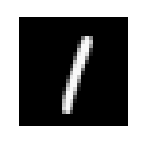

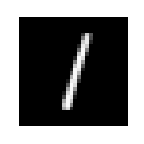

In [44]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision.utils import make_grid
import numpy as np
import random

@torch.no_grad()
def get_digit_latents_multi(digit_list, val_loader, model, device, n_per_digit=5):
    """Finds up to n_per_digit latent vectors for each digit in digit_list from val_loader."""
    latents = {d: [] for d in digit_list}
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            mu, _ = model.encoder(x)
        for d in digit_list:
            idx = (y == d).nonzero(as_tuple=True)[0]
            for i in idx:
                if len(latents[d]) < n_per_digit:
                    latents[d].append(mu[i].unsqueeze(0))
        # Early exit if all digits have enough latents
        if all(len(latents[d]) >= n_per_digit for d in digit_list):
            break
    # If any digit is missing, fill with random latent(s)
    for d in digit_list:
        while len(latents[d]) < n_per_digit:
            latents[d].append(torch.randn(1, model.latent_dim, device=device))
    return latents

def animate_latent_traversal(digit_sequence, latents_multi, model, output_path, n_interp=16, duration=100):
    """Creates an animation interpolating through the given digit_sequence.
    For each digit, randomly pick a latent from the available ones."""
    z_list = []
    for d in digit_sequence:
        z_list.append(random.choice(latents_multi[d]))
    frames = []
    for i in range(len(z_list)-1):
        z_start = z_list[i]
        z_end = z_list[i+1]
        for alpha in np.linspace(0, 1, n_interp):
            z = (1 - alpha) * z_start + alpha * z_end
            sample = model.decoder(z)
            sample = torch.sigmoid(sample) if sample.min() < 0 else sample
            grid = make_grid(sample, nrow=1, padding=2, normalize=True)
            img = grid.permute(1,2,0).cpu().numpy()
            frames.append(img)
    # Last digit
    sample = model.decoder(z_list[-1])
    sample = torch.sigmoid(sample) if sample.min() < 0 else sample
    grid = make_grid(sample, nrow=1, padding=2, normalize=True)
    img = grid.permute(1,2,0).cpu().numpy()
    frames.append(img)

    fig = plt.figure(figsize=(2,2))
    plt.axis('off')
    im = plt.imshow(frames[0], animated=True)

    def updatefig(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=duration, blit=True)
    ani.save(output_path, writer='pillow')
    plt.close(fig)

# --- Prepare digit sequences ---
# Digits 1 to 9
digits_1_to_9 = list(range(1, 10))

# First 30 digits of pi (excluding the initial '3')
pi_digits_str = "141592653589793238462643383279"
pi_digits = [int(d) for d in pi_digits_str]

# --- Get multiple latents for all needed digits ---
all_needed_digits = set(digits_1_to_9) | set(pi_digits)
latents_multi = get_digit_latents_multi(list(all_needed_digits), val_loader, model, cfg.device, n_per_digit=5)

# --- Animate 1 to 9 ---
output_path_1to9 = os.path.join(cfg.output_dir, "anim_1_to_9.gif")
animate_latent_traversal(digits_1_to_9, latents_multi, model, output_path_1to9, n_interp=16, duration=100)
print(f"Saved animation: {output_path_1to9}")

# --- Animate pi digits ---
output_path_pi = os.path.join(cfg.output_dir, "anim_pi_digits.gif")
animate_latent_traversal(pi_digits, latents_multi, model, output_path_pi, n_interp=8, duration=80)
print(f"Saved animation: {output_path_pi}")

# Optionally, display the animations in notebook
from IPython.display import Image, display
if os.path.exists(output_path_1to9):
    display(Image(filename=output_path_1to9))
if os.path.exists(output_path_pi):
    display(Image(filename=output_path_pi))


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


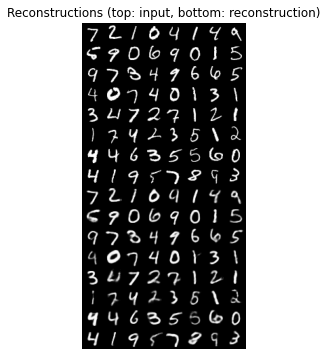

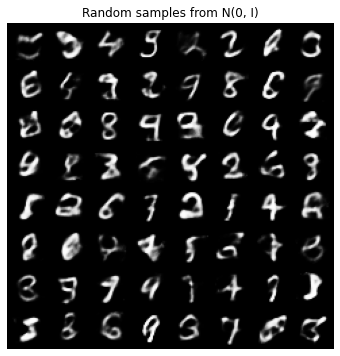

In [37]:
# Visualization
import matplotlib.pyplot as plt

@torch.no_grad()
def show_grid(img_path, title=None):
    img = plt.imread(img_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Display last saved grids if they exist
recon_path = os.path.join(cfg.output_dir, f"recon_epoch_{cfg.epochs:03d}.png")
samples_path = os.path.join(cfg.output_dir, f"samples_epoch_{cfg.epochs:03d}.png")
if os.path.exists(recon_path):
    show_grid(recon_path, title="Reconstructions (top: input, bottom: reconstruction)")
if os.path.exists(samples_path):
    show_grid(samples_path, title="Random samples from N(0, I)")


In [25]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Number of devices: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")


CUDA is available. Number of devices: 1
Current device: 0
Device name: NVIDIA A100-SXM4-40GB
